In [1]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
MLP_RESULTS_PATH = "models_norm/MLP_preds"
RNN_RESULTS_PATH = "models_norm/RNN_preds"
PSN_RESULTS_PATH = "models_norm/PSN_preds"

## Train and Evaluate a single model

### Setup Parameters

In [3]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [4]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [5]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'


if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

### Instanciate Model

In [6]:
model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 300

model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [7]:
model.train(trainloader, validloader)

[00:00] Epoch 1/300 - Train Loss : 1.005553 / Val Loss : 1.001779
[00:33] Epoch 100/300 - Train Loss : 0.923312 / Val Loss : 1.044391
[01:08] Epoch 200/300 - Train Loss : 0.777750 / Val Loss : 1.175129
[01:41] Epoch 300/300 - Train Loss : 0.697501 / Val Loss : 1.258081
Train MAE : 0.6117 | Train MAPE  : 238.5600 | Train RMSE : 0.8213 | Train Theil-U 0.5503
Valid MAE : 0.8630 | Valid MAPE  : 229.9809 | Valid RMSE : 1.1216 | Valid Theil-U 0.7529


### Evaluation

In [8]:
if NNtype != "PSN":
    model.evaluate(testloader, mu=testmu, sigma=testsigma)
else:
    model.evaluate(testloader, min_=min_, max_=max_)

Normalized Test MAE : 0.006067 | Test MAPE  : 30595.854983 | Test RMSE : 0.008046 | Test Theil-U 0.735517


### PREDICT

(array([  2.,   7.,  22.,  68., 118.,  64.,  18.,  10.,   7.,   5.]),
 array([-0.01101674, -0.00854476, -0.00607277, -0.00360078, -0.00112879,
         0.00134319,  0.00381518,  0.00628717,  0.00875916,  0.01123114,
         0.01370313]),
 <a list of 10 Patch objects>)

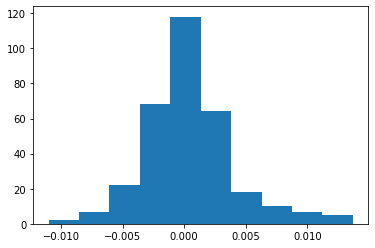

In [9]:
if NNtype != "PSN":
    predictions = model.predict(testloader, mu=testmu, sigma=testsigma)
else:
    predictions = model.predict(testloader, min_=min_, max_=max_)
plt.hist(np.array(predictions))

Text(0.5, 1.0, 'UnNormalized')

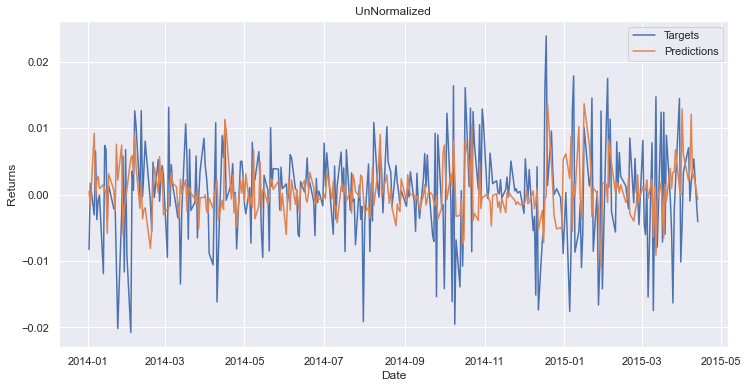

In [10]:
if NNtype == "PSN":
    targets = testdf["Target"]*(max_ - min_) + min_
else :
    targets = testdf["Target"].tolist()

dataDf = pd.DataFrame({'Predictions':predictions, 'Targets':targets})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

# x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")

## Train and Evaluate All Models

In [11]:
ETF = 'QQQ'
NNtype = 'PSN'

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    max_test, min_test = testdf.Return.max(), testdf.Return.min()
    
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_test) / (max_test - min_test)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 300
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:33] Epoch 100/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[01:05] Epoch 200/200 - Train Loss : 0.018489 / Val Loss : 0.011347
Train MAE : 0.1075 | Train MAPE  : 19.2045 | Train RMSE : 0.1360 | Train Theil-U 0.1255
Valid MAE : 0.0923 | Valid MAPE  : 15.3798 | Valid RMSE : 0.1065 | Valid Theil-U 0.0983


Normalized Test MAE : 0.007491 | Test MAPE  : 2949660.667270 | Test RMSE : 0.009427 | Test Theil-U 0.815068
Test MAE : 0.007491 | Test MAPE  : 207.897263 | Test RMSE : 0.009427 | Test Theil-U 0.815068


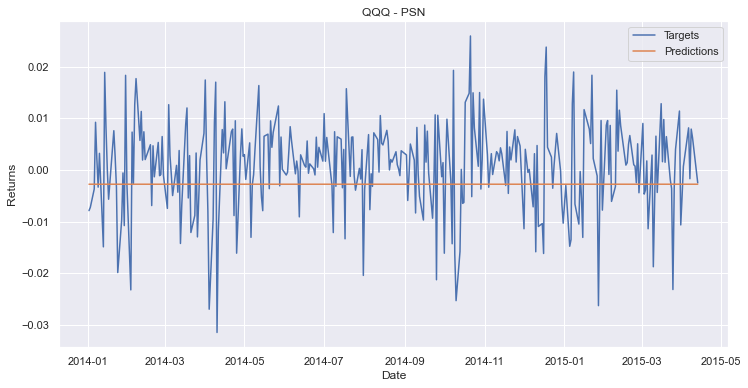

In [12]:
if NNtype == "PSN":
    model.evaluate(testloader, min_=min_test, max_=max_test)
    preds = model.predict(testloader, min_=min_test, max_=max_test)
    labels = testdf["Target"]*(max_test - min_test) + min_test
else :
    model.evaluate(testloader, sigma=testsigma, mu=testmu)
    preds = model.predict(testloader, sigma=testsigma, mu=testmu)
    labels = np.array(testdf["Target"].tolist())

testRMSE = np.sqrt(mean_squared_error(labels, preds))
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
testTheilU = theilU(np.array(labels), np.array(preds))

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

ax.set_ylabel('Returns')
ax.set_title(ETF + " - " + NNtype)
plt.show() 

# Test par NNtype

## MLP

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.004274 / Val Loss : 1.002128
[00:32] Epoch 100/300 - Train Loss : 0.879552 / Val Loss : 1.012844
[01:05] Epoch 200/300 - Train Loss : 0.841754 / Val Loss : 1.079911
[01:37] Epoch 300/300 - Train Loss : 0.816344 / Val Loss : 1.121056
Train MAE : 0.6472 | Train MAPE  : 210.8565 | Train RMSE : 0.8937 | Train Theil-U 0.6208
Valid MAE : 0.8166 | Valid MAPE  : 160.6841 | Valid RMSE : 1.0588 | Valid Theil-U 0.7515
Normalized Test MAE : 0.005794 | Test MAPE  : 214.763953 | Test RMSE : 0.007791 | Test Theil-U 0.735652
Test MAE : 0.005802 | Test MAPE  : 187.800553 | Test RMSE : 0.007765 | Test Theil-U 0.732202


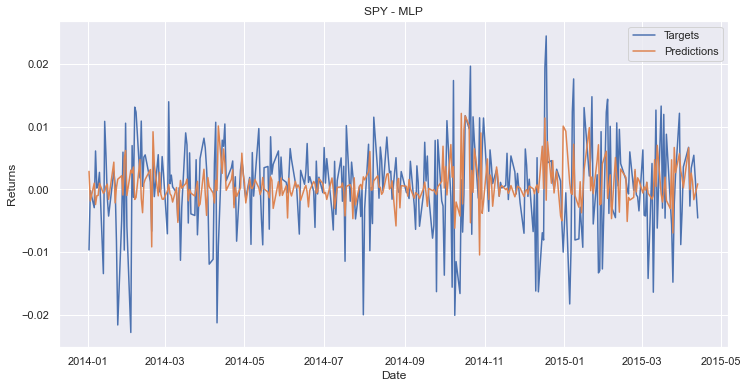

==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.030102 / Val Loss : 1.001289
[00:31] Epoch 100/300 - Train Loss : 0.913304 / Val Loss : 1.049597
[01:09] Epoch 200/300 - Train Loss : 0.786598 / Val Loss : 1.192592
[01:47] Epoch 300/300 - Train Loss : 0.736530 / Val Loss : 1.257315
Train MAE : 0.6231 | Train MAPE  : 229.6275 | Train RMSE : 0.8448 | Train Theil-U 0.5734
Valid MAE : 0.8608 | Valid MAPE  : 204.6490 | Valid RMSE : 1.1213 | Valid Theil-U 0.7705
Normalized Test MAE : 0.006153 | Test MAPE  : 62929.833715 | Test RMSE : 0.008201 | Test Theil-U 0.766169
Test MAE : 0.006165 | Test MAPE  : 199.841862 | Test RMSE : 0.008193 | Test Theil-U 0.764890


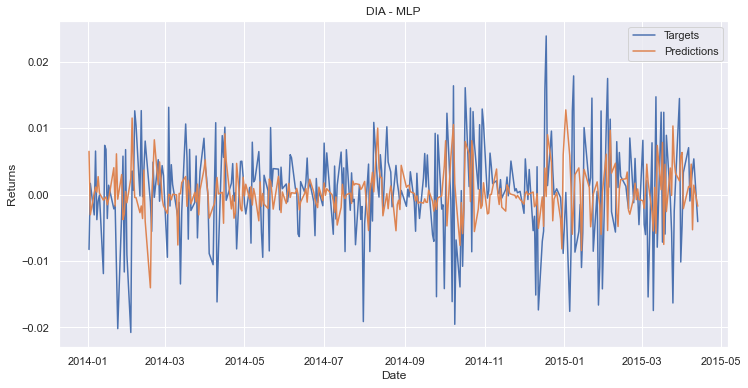

==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.026671 / Val Loss : 1.001021
[00:32] Epoch 100/300 - Train Loss : 0.912433 / Val Loss : 0.960803
[01:06] Epoch 200/300 - Train Loss : 0.743478 / Val Loss : 1.077402
[01:38] Epoch 300/300 - Train Loss : 0.692694 / Val Loss : 1.210379
Train MAE : 0.6224 | Train MAPE  : 234.2174 | Train RMSE : 0.8114 | Train Theil-U 0.5205
Valid MAE : 0.8429 | Valid MAPE  : 304.3986 | Valid RMSE : 1.1002 | Valid Theil-U 0.6912
Normalized Test MAE : 0.007715 | Test MAPE  : 555.079444 | Test RMSE : 0.010163 | Test Theil-U 0.754337
Test MAE : 0.007840 | Test MAPE  : 263.428866 | Test RMSE : 0.010217 | Test Theil-U 0.756875


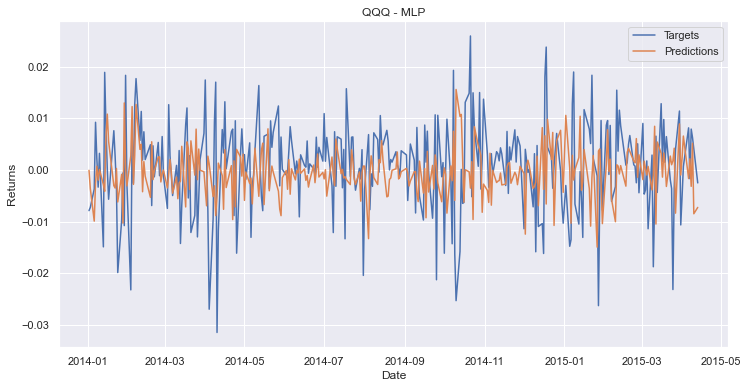

In [13]:
# train all models of a particular NNType
MLPPredictions = {}

for ETF in ['SPY', 'DIA', 'QQQ']:
    NNtype = 'MLP'

    print("="*10 + ETF + " - " + NNtype + "="*10)
    params = cfg.train_parameters[ETF][NNtype]
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'

    if NNtype != "PSN":
        trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
        validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
        testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    else:
        max_ = traindf.Return.max()
        min_ = traindf.Return.min()
        
        traindf = (traindf - min_) / (max_ - min_)
        validdf = (validdf - min_) / (max_ - min_)
        testdf = (testdf - min_) / (max_ - min_)

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

    model = NN.Model(NNtype)
#     epochs = 200
    epochs = 200 if NNtype == "PSN" else 300
    model.setup(params["input_size"], 
                params["hidden_size"],
                params["output_size"],
                epochs,#params["epochs"],
                params["optim"],
                params["lr"],
                params["momentum"]
               )

    model.train(trainloader, validloader)

    if NNtype == "PSN":
        model.evaluate(testloader, min_=min_, max_=max_)
        preds = model.predict(testloader, min_=min_, max_=max_)
        labels = testdf["Target"]*(max_ - min_) + min_
    else :
        model.evaluate(testloader, sigma=testsigma, mu=testmu)
        preds = model.predict(testloader, sigma=testsigma, mu=testmu)
        labels = np.array(testdf["Target"].tolist())

    testRMSE = np.sqrt(mean_squared_error(labels, preds))
    testMAE = mean_absolute_error(labels, preds)
    testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
    testTheilU = theilU(np.array(labels), np.array(preds))

    print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

    ## plot Target and Predictions UnNormalized ##
    dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
    dataDf.index = testdf.index
    dataDf

    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
    sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - " + NNtype)
    plt.show()
    
    MLPPredictions[ETF] = preds

## RNN

==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.084656 / Val Loss : 0.999602
[00:47] Epoch 100/300 - Train Loss : 0.758252 / Val Loss : 1.139200
[01:35] Epoch 200/300 - Train Loss : 0.712153 / Val Loss : 1.224270
[02:30] Epoch 300/300 - Train Loss : 0.694853 / Val Loss : 1.267294
Train MAE : 0.6159 | Train MAPE  : 320.0647 | Train RMSE : 0.8121 | Train Theil-U 0.5208
Valid MAE : 0.8360 | Valid MAPE  : 195.5377 | Valid RMSE : 1.1257 | Valid Theil-U 0.7399
Normalized Test MAE : 0.005957 | Test MAPE  : 199.196441 | Test RMSE : 0.007974 | Test Theil-U 0.728610
Test MAE : 0.005983 | Test MAPE  : 227.622394 | Test RMSE : 0.007956 | Test Theil-U 0.725990


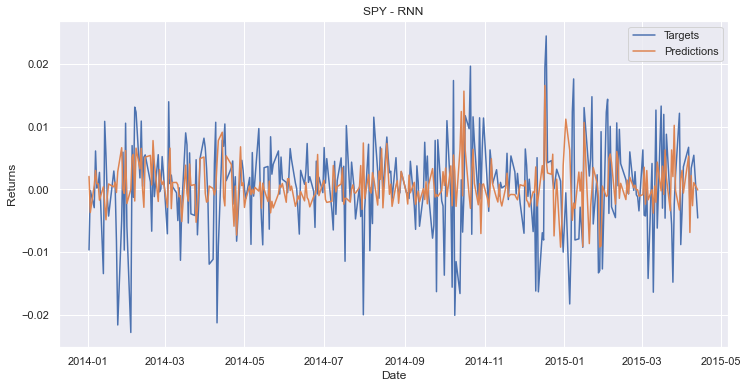

==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.042410 / Val Loss : 1.012216
[00:51] Epoch 100/300 - Train Loss : 0.765747 / Val Loss : 1.234709
[01:47] Epoch 200/300 - Train Loss : 0.734889 / Val Loss : 1.320570
[02:44] Epoch 300/300 - Train Loss : 0.713036 / Val Loss : 1.369137
Train MAE : 0.6213 | Train MAPE  : 324.6667 | Train RMSE : 0.8276 | Train Theil-U 0.5284
Valid MAE : 0.8956 | Valid MAPE  : 290.4396 | Valid RMSE : 1.1701 | Valid Theil-U 0.7099
Normalized Test MAE : 0.006740 | Test MAPE  : 1606.553631 | Test RMSE : 0.008818 | Test Theil-U 0.746898
Test MAE : 0.006749 | Test MAPE  : 271.272041 | Test RMSE : 0.008787 | Test Theil-U 0.743746


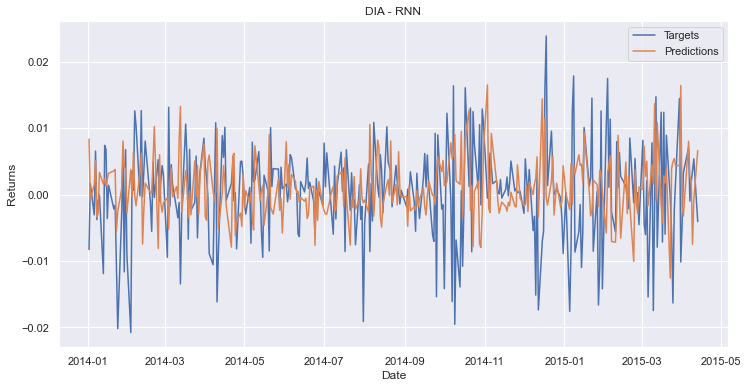

==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.046271 / Val Loss : 1.005907
[00:52] Epoch 100/300 - Train Loss : 0.735361 / Val Loss : 1.293903
[01:41] Epoch 200/300 - Train Loss : 0.651726 / Val Loss : 1.633237
[02:31] Epoch 300/300 - Train Loss : 0.616187 / Val Loss : 1.783244
Train MAE : 0.5894 | Train MAPE  : 277.3318 | Train RMSE : 0.7627 | Train Theil-U 0.4640
Valid MAE : 1.0381 | Valid MAPE  : 675.6304 | Valid RMSE : 1.3354 | Valid Theil-U 0.7331
Normalized Test MAE : 0.008229 | Test MAPE  : 627.191618 | Test RMSE : 0.010526 | Test Theil-U 0.699577
Test MAE : 0.008256 | Test MAPE  : 315.306974 | Test RMSE : 0.010520 | Test Theil-U 0.697955


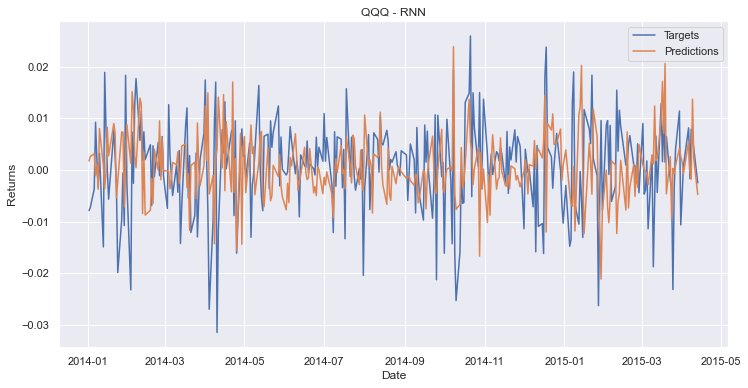

In [14]:
RNNPredictions = {}

# train all models of a particular NNType
for ETF in ['SPY', 'DIA', 'QQQ']:
    NNtype = 'RNN'

    print("="*10 + ETF + " - " + NNtype + "="*10)
    params = cfg.train_parameters[ETF][NNtype]
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'

    if NNtype != "PSN":
        trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
        validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
        testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    else:
        max_ = traindf.Return.max()
        min_ = traindf.Return.min()
        max_test, min_test = testdf.Return.max(), testdf.Return.min()

        traindf = (traindf - min_) / (max_ - min_)
        validdf = (validdf - min_) / (max_ - min_)
        testdf = (testdf - min_) / (max_ - min_)

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

    model = NN.Model(NNtype)
#     epochs = 200
    epochs = 200 if NNtype == "PSN" else 300
    model.setup(params["input_size"], 
                params["hidden_size"],
                params["output_size"],
                epochs,#params["epochs"],
                params["optim"],
                params["lr"],
                params["momentum"]
               )

    model.train(trainloader, validloader)

    if NNtype == "PSN":
        model.evaluate(testloader, min_=min_, max_=max_)
        preds = model.predict(testloader, min_=min_, max_=max_)
        labels = testdf["Target"]*(max_ - min_) + min_
    else :
        model.evaluate(testloader, sigma=testsigma, mu=testmu)
        preds = model.predict(testloader, sigma=testsigma, mu=testmu)
        labels = np.array(testdf["Target"].tolist())

    testRMSE = np.sqrt(mean_squared_error(labels, preds))
    testMAE = mean_absolute_error(labels, preds)
    testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
    testTheilU = theilU(np.array(labels), np.array(preds))

    print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

    ## plot Target and Predictions UnNormalized ##
    dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
    dataDf.index = testdf.index
    dataDf

    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
    sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - " + NNtype)
    plt.show()
    
    RNNPredictions[ETF] = preds

# PSN

==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.015973 / Val Loss : 0.005435
[00:33] Epoch 100/200 - Train Loss : 0.012877 / Val Loss : 0.007521
[01:06] Epoch 200/200 - Train Loss : 0.012620 / Val Loss : 0.007549
Train MAE : 0.0913 | Train MAPE  : 16.1229 | Train RMSE : 0.1199 | Train Theil-U 0.1016
Valid MAE : 0.0740 | Valid MAPE  : 11.9882 | Valid RMSE : 0.0869 | Valid Theil-U 0.0748
Normalized Test MAE : 0.015455 | Test MAPE  : 1131.656271 | Test RMSE : 0.018007 | Test Theil-U 0.746232
Test MAE : 0.015455 | Test MAPE  : 1131.656890 | Test RMSE : 0.018007 | Test Theil-U 0.746232


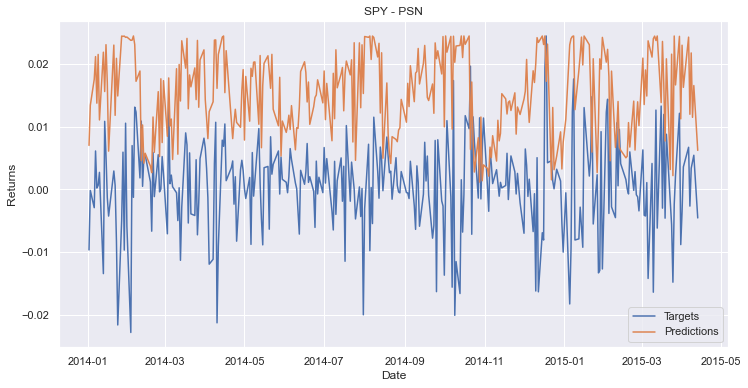

==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020697 / Val Loss : 0.013877
[00:33] Epoch 100/200 - Train Loss : 0.013837 / Val Loss : 0.007082
[01:06] Epoch 200/200 - Train Loss : 0.013746 / Val Loss : 0.007237
Train MAE : 0.0861 | Train MAPE  : 16.5248 | Train RMSE : 0.1170 | Train Theil-U 0.1003
Valid MAE : 0.0701 | Valid MAPE  : 11.6693 | Valid RMSE : 0.0851 | Valid Theil-U 0.0735
Normalized Test MAE : 0.013656 | Test MAPE  : 7012739.260600 | Test RMSE : 0.016031 | Test Theil-U 0.732103
Test MAE : 0.013656 | Test MAPE  : 861.651169 | Test RMSE : 0.016031 | Test Theil-U 0.732103


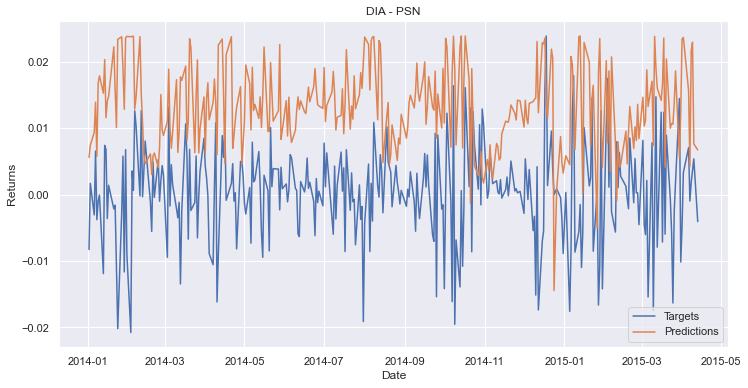

==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:33] Epoch 100/200 - Train Loss : 0.014388 / Val Loss : 0.005741
[01:10] Epoch 200/200 - Train Loss : 0.014183 / Val Loss : 0.005994
Train MAE : 0.0884 | Train MAPE  : 17.0279 | Train RMSE : 0.1170 | Train Theil-U 0.1026
Valid MAE : 0.0610 | Valid MAPE  : 10.6047 | Valid RMSE : 0.0774 | Valid Theil-U 0.0683
Normalized Test MAE : 0.006932 | Test MAPE  : 2469387.078529 | Test RMSE : 0.009129 | Test Theil-U 0.730688
Test MAE : 0.006932 | Test MAPE  : 199.572814 | Test RMSE : 0.009129 | Test Theil-U 0.730688


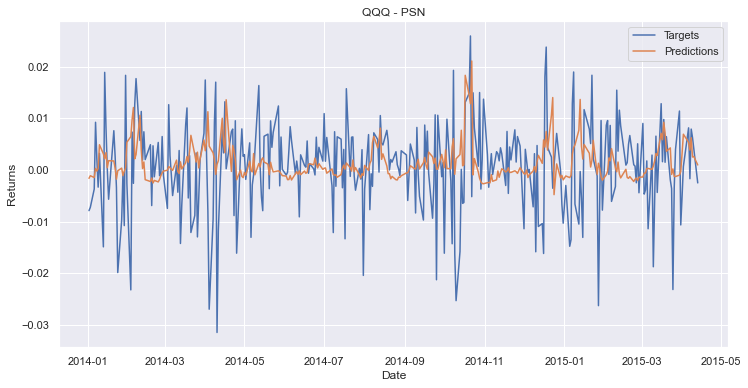

In [15]:
PSNPredictions = {}

# train all models of a particular NNType
for ETF in ['SPY', 'DIA', 'QQQ']:
    NNtype = 'PSN'

    print("="*10 + ETF + " - " + NNtype + "="*10)
    params = cfg.train_parameters[ETF][NNtype]
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'

    if NNtype != "PSN":
        trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
        validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
        testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    else:
        max_ = traindf.Return.max()
        min_ = traindf.Return.min()
        max_test, min_test = testdf.Return.max(), testdf.Return.min()

        traindf = (traindf - min_) / (max_ - min_)
        validdf = (validdf - min_) / (max_ - min_)
#         testdf = (testdf - min_) / (max_ - min_)
        testdf = (testdf - min_test) / (max_test - min_test)

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

    model = NN.Model(NNtype)
    epochs = 200 if NNtype == "PSN" else 500
    model.setup(params["input_size"], 
                params["hidden_size"],
                params["output_size"],
                epochs,#params["epochs"],
                params["optim"],
                params["lr"],
                params["momentum"]
               )

    model.train(trainloader, validloader)

    if NNtype == "PSN":
#         model.evaluate(testloader, min_=min_, max_=max_)
#         preds = model.predict(testloader, min_=min_, max_=max_)
#         labels = testdf["Target"]*(max_ - min_) + min_
        
        model.evaluate(testloader, min_=min_test, max_=max_test)
        preds = model.predict(testloader, min_=min_test, max_=max_test)
        labels = testdf["Target"]*(max_test - min_test) + min_test
    else :
        model.evaluate(testloader, sigma=testsigma, mu=testmu)
        preds = model.predict(testloader, sigma=testsigma, mu=testmu)
        labels = np.array(testdf["Target"].tolist())

    testRMSE = np.sqrt(mean_squared_error(labels, preds))
    testMAE = mean_absolute_error(labels, preds)
    testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
    testTheilU = theilU(np.array(labels), np.array(preds))

    print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

    ## plot Target and Predictions UnNormalized ##
    dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
    dataDf.index = testdf.index
    dataDf

    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
    sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - " + NNtype)
    plt.show()

    PSNPredictions[ETF] = preds

## Train all Models and create Table4

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.023856 / Val Loss : 0.979619
[00:33] Epoch 100/300 - Train Loss : 0.905914 / Val Loss : 1.002144
[01:13] Epoch 200/300 - Train Loss : 0.863215 / Val Loss : 1.033187
[01:53] Epoch 300/300 - Train Loss : 0.823766 / Val Loss : 1.076747
Train MAE : 0.6610 | Train MAPE  : 257.3266 | Train RMSE : 0.9056 | Train Theil-U 0.6371
Valid MAE : 0.8012 | Valid MAPE  : 142.5267 | Valid RMSE : 1.0377 | Valid Theil-U 0.7763
Normalized Test MAE : 0.005886 | Test MAPE  : 184.268998 | Test RMSE : 0.007820 | Test Theil-U 0.773377
Test MAE : 0.005906 | Test MAPE  : 19382.197594 | Test RMSE : 0.007784 | Test Theil-U 0.768795


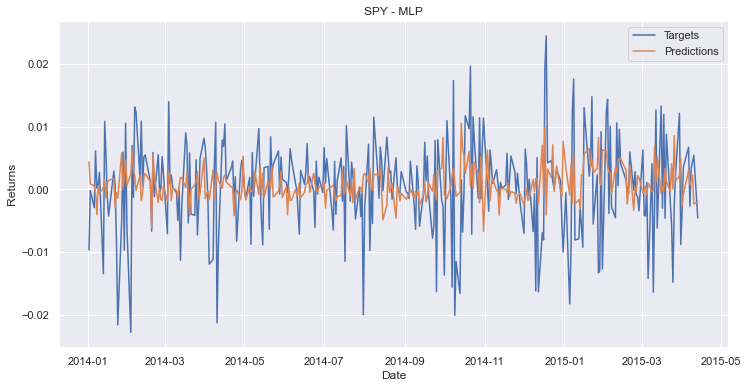




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.067593 / Val Loss : 0.996249
[00:47] Epoch 100/300 - Train Loss : 0.737873 / Val Loss : 1.308553
[01:34] Epoch 200/300 - Train Loss : 0.705005 / Val Loss : 1.375836
[02:21] Epoch 300/300 - Train Loss : 0.689083 / Val Loss : 1.395372
Train MAE : 0.5959 | Train MAPE  : 247.0766 | Train RMSE : 0.8096 | Train Theil-U 0.5105
Valid MAE : 0.9280 | Valid MAPE  : 238.6613 | Valid RMSE : 1.1813 | Valid Theil-U 0.7340
Normalized Test MAE : 0.006247 | Test MAPE  : 270.167032 | Test RMSE : 0.008362 | Test Theil-U 0.697157
Test MAE : 0.006307 | Test MAPE  : 21687.941159 | Test RMSE : 0.008398 | Test Theil-U 0.699333


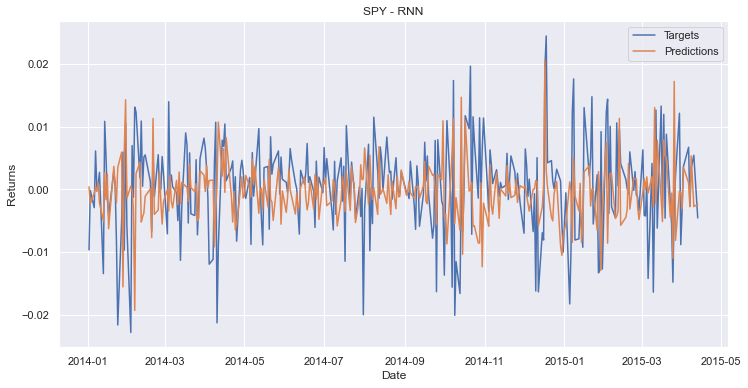




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020829 / Val Loss : 0.015236
[00:31] Epoch 100/200 - Train Loss : 0.012515 / Val Loss : 0.007563
[01:03] Epoch 200/200 - Train Loss : 0.012661 / Val Loss : 0.007604
Train MAE : 0.0917 | Train MAPE  : 16.2056 | Train RMSE : 0.1205 | Train Theil-U 0.1021
Valid MAE : 0.0744 | Valid MAPE  : 12.0477 | Valid RMSE : 0.0872 | Valid Theil-U 0.0751
Normalized Test MAE : 0.008430 | Test MAPE  : 521.178128 | Test RMSE : 0.009862 | Test Theil-U 0.709885
Test MAE : 0.008430 | Test MAPE  : 52117.995568 | Test RMSE : 0.009862 | Test Theil-U 0.709885


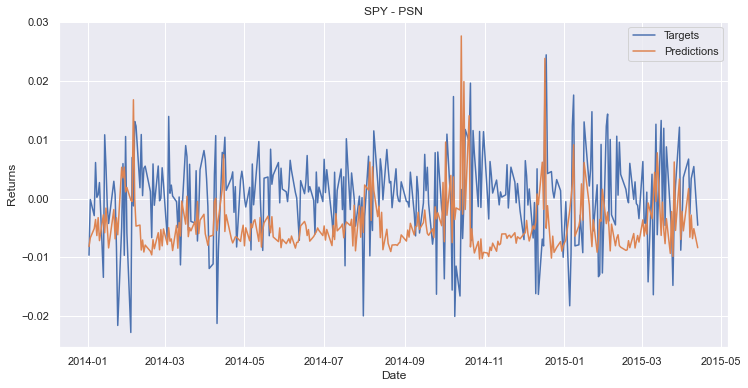




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.027179 / Val Loss : 1.003657
[00:33] Epoch 100/300 - Train Loss : 0.936473 / Val Loss : 1.017505
[01:06] Epoch 200/300 - Train Loss : 0.815656 / Val Loss : 1.085097
[01:38] Epoch 300/300 - Train Loss : 0.750434 / Val Loss : 1.192392
Train MAE : 0.6458 | Train MAPE  : 289.1245 | Train RMSE : 0.8541 | Train Theil-U 0.5870
Valid MAE : 0.8545 | Valid MAPE  : 266.9721 | Valid RMSE : 1.0920 | Valid Theil-U 0.7459
Normalized Test MAE : 0.006040 | Test MAPE  : 35530.118430 | Test RMSE : 0.007986 | Test Theil-U 0.738819
Test MAE : 0.006054 | Test MAPE  : 19709.104977 | Test RMSE : 0.007979 | Test Theil-U 0.737609


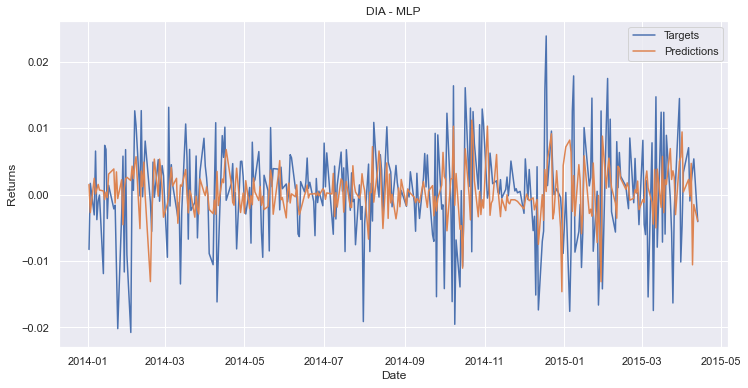




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.056873 / Val Loss : 0.998010
[00:46] Epoch 100/300 - Train Loss : 0.783924 / Val Loss : 1.327479
[01:32] Epoch 200/300 - Train Loss : 0.754617 / Val Loss : 1.381734
[02:19] Epoch 300/300 - Train Loss : 0.744619 / Val Loss : 1.381253
Train MAE : 0.6300 | Train MAPE  : 282.5297 | Train RMSE : 0.8383 | Train Theil-U 0.5409
Valid MAE : 0.8796 | Valid MAPE  : 251.8159 | Valid RMSE : 1.1753 | Valid Theil-U 0.7333
Normalized Test MAE : 0.006679 | Test MAPE  : 36793.874500 | Test RMSE : 0.008615 | Test Theil-U 0.737219
Test MAE : 0.006704 | Test MAPE  : 24960.073570 | Test RMSE : 0.008612 | Test Theil-U 0.736417


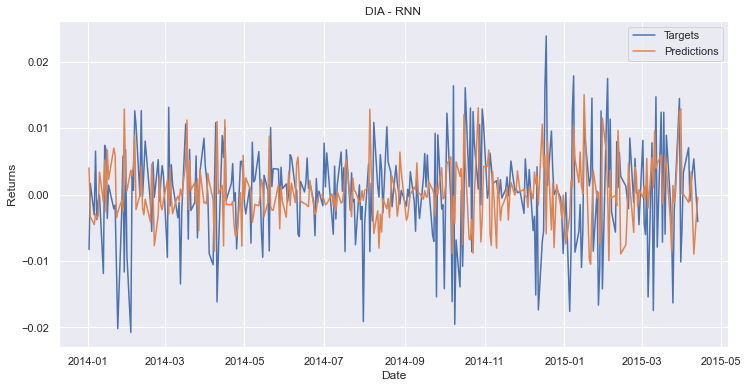




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.015213 / Val Loss : 0.005920
[00:32] Epoch 100/200 - Train Loss : 0.013808 / Val Loss : 0.007060
[01:04] Epoch 200/200 - Train Loss : 0.013790 / Val Loss : 0.007203
Train MAE : 0.0858 | Train MAPE  : 16.4877 | Train RMSE : 0.1169 | Train Theil-U 0.1003
Valid MAE : 0.0699 | Valid MAPE  : 11.6400 | Valid RMSE : 0.0849 | Valid Theil-U 0.0733
Normalized Test MAE : 0.006781 | Test MAPE  : 1791306.722781 | Test RMSE : 0.008298 | Test Theil-U 0.728863
Test MAE : 0.006781 | Test MAPE  : 34733352387951592.000000 | Test RMSE : 0.008298 | Test Theil-U 0.728863


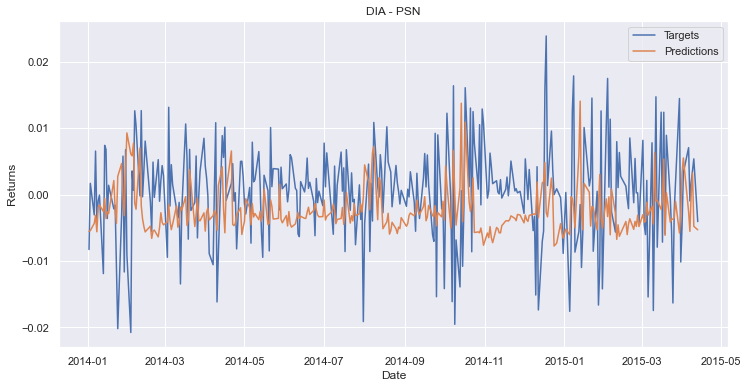




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.027225 / Val Loss : 1.006040
[00:39] Epoch 100/300 - Train Loss : 0.862375 / Val Loss : 0.967820
[01:12] Epoch 200/300 - Train Loss : 0.763913 / Val Loss : 1.064536
[01:47] Epoch 300/300 - Train Loss : 0.713912 / Val Loss : 1.158797
Train MAE : 0.6515 | Train MAPE  : 255.1199 | Train RMSE : 0.8232 | Train Theil-U 0.5386
Valid MAE : 0.8242 | Valid MAPE  : 514.6072 | Valid RMSE : 1.0765 | Valid Theil-U 0.7067
Normalized Test MAE : 0.007681 | Test MAPE  : 328.721432 | Test RMSE : 0.010186 | Test Theil-U 0.757985
Test MAE : 0.007791 | Test MAPE  : 20913.062553 | Test RMSE : 0.010229 | Test Theil-U 0.759691


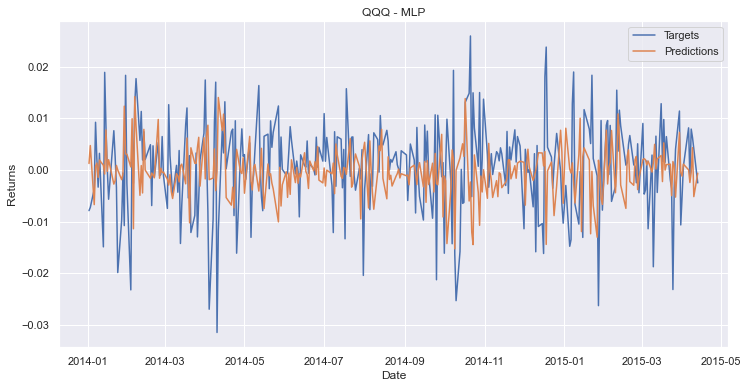




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/300 - Train Loss : 1.033516 / Val Loss : 1.003757
[00:56] Epoch 100/300 - Train Loss : 0.716234 / Val Loss : 1.325665
[01:52] Epoch 200/300 - Train Loss : 0.627672 / Val Loss : 1.393875
[02:53] Epoch 300/300 - Train Loss : 0.604501 / Val Loss : 1.409550
Train MAE : 0.5804 | Train MAPE  : 346.5568 | Train RMSE : 0.7580 | Train Theil-U 0.4576
Valid MAE : 0.9093 | Valid MAPE  : 456.6414 | Valid RMSE : 1.1872 | Valid Theil-U 0.6909
Normalized Test MAE : 0.008693 | Test MAPE  : 828.083509 | Test RMSE : 0.011188 | Test Theil-U 0.732085
Test MAE : 0.008718 | Test MAPE  : 31797.425509 | Test RMSE : 0.011163 | Test Theil-U 0.729143


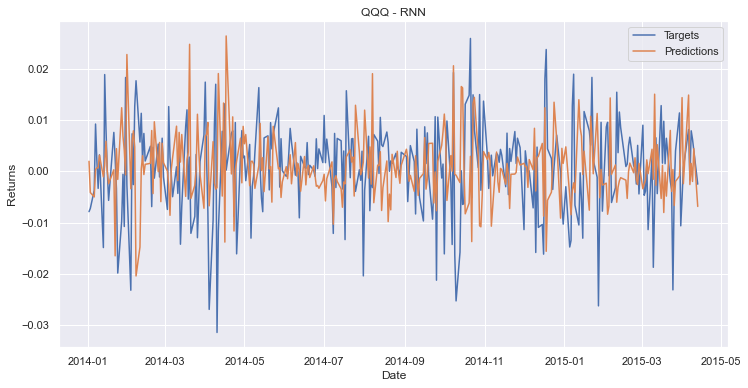




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018493 / Val Loss : 0.011350
[00:47] Epoch 100/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[01:27] Epoch 200/200 - Train Loss : 0.014225 / Val Loss : 0.005959
Train MAE : 0.0876 | Train MAPE  : 17.2351 | Train RMSE : 0.1165 | Train Theil-U 0.1023
Valid MAE : 0.0606 | Valid MAPE  : 10.5038 | Valid RMSE : 0.0772 | Valid Theil-U 0.0681
Normalized Test MAE : 0.007299 | Test MAPE  : 464841.088953 | Test RMSE : 0.009152 | Test Theil-U 0.797771
Test MAE : 0.007299 | Test MAPE  : 20876541685034168.000000 | Test RMSE : 0.009152 | Test Theil-U 0.797771


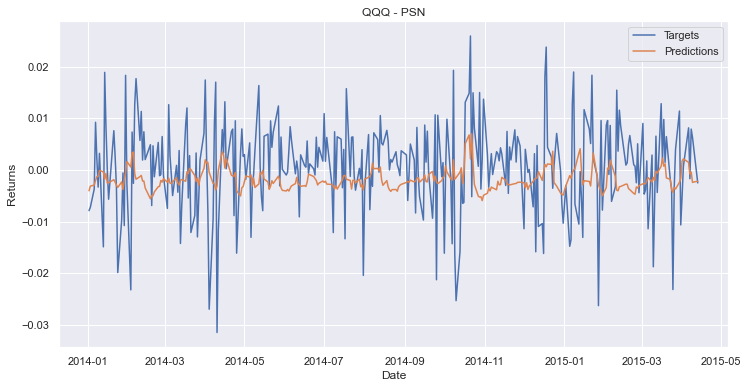

In [20]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']: 
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
            validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
            testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

        else:
            max_ = traindf.Return.max()
            min_ = traindf.Return.min()
            
            traindf = (traindf - min_) / (max_ - min_)
            validdf = (validdf - min_) / (max_ - min_)
            testdf = (testdf - min_) / (max_ - min_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)
            
            
        model = NN.Model(NNtype)
#         epochs = 200
        epochs = 200 if NNtype == "PSN" else 300 # 300 to avoid overfitting
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    epochs,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        
        if NNtype == "PSN":
            model.evaluate(testloader, min_=min_, max_=max_)
            preds = model.predict(testloader, min_=min_, max_=max_)
            labels = testdf["Target"]*(max_ - min_) + min_
        else :
            model.evaluate(testloader, sigma=testsigma, mu=testmu)
            preds = model.predict(testloader, sigma=testsigma, mu=testmu)
            labels = np.array(testdf["Target"].tolist())
        
        testRMSE = np.sqrt(mean_squared_error(labels, preds))
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = 100 * mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        ## plot Target and Predictions UnNormalized ##
        dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
        dataDf.index = testdf.index
        
        sns.set()
        fig, ax = plt.subplots(figsize = (12,6))
        sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
        sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

#         x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
#         ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
        ax.set_ylabel('Returns')
        ax.set_title(ETF + " - " + NNtype)
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [21]:
# save models
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

In [22]:
# save predictions

MLPpredDf = pd.DataFrame(MLPPredictions)
RNNpredDf = pd.DataFrame(RNNPredictions)
PSNpredDf = pd.DataFrame(PSNPredictions)

if not os.path.isdir(MLP_RESULTS_PATH):
    os.mkdir(MLP_RESULTS_PATH)
    
if not os.path.isdir(RNN_RESULTS_PATH):
    os.mkdir(RNN_RESULTS_PATH)
    
if not os.path.isdir(PSN_RESULTS_PATH):
    os.mkdir(PSN_RESULTS_PATH)

MLPpredDf.to_csv(MLP_RESULTS_PATH + "/Predictions", index=False)
RNNpredDf.to_csv(RNN_RESULTS_PATH + "/Predictions", index=False)
PSNpredDf.to_csv(PSN_RESULTS_PATH + "/Predictions", index=False)


### Load Ckpt

In [19]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.273237 | Test MAPE  : 18218.310221 | Test RMSE : 0.273335 | Test Theil-U 0.975612


# To work

# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined